<a href="https://colab.research.google.com/github/doyooni303/NewNLPStudy/blob/main/%5BPytorch_NLP%5D_Simpson_Character_Line_Classification_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시작

In [ ]:
from IPython.display import display
import IPython
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
!pip install mglearn
!pip install gensim
!pip install nltk
import nltk
import mglearn as mglearn
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext

torch.manual_seed(1)


In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
import os,sys
os.chdir('/content')

In [ ]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# Data 업로드 : Content 폴더에

In [ ]:
# API Token 다운받기
# 다운받은 API Token 업로드 하기
!pip install kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"doyooni303","key":"91fac564146b8719aa4482ee9779aca2"}'}

In [ ]:
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
#!kaggle competitions list
# 데이터셋 다운로드 받기 - 링크는 그 대회 'Data'에 있음
! kaggle datasets download -d pierremegret/dialogue-lines-of-the-simpsons
# 다운로드 된 것들 다 보기 
!ls
# 필요하면 압축 풀기 
!unzip dialogue-lines-of-the-simpsons.zip

dialogue-lines-of-the-simpsons.zip: Skipping, found more recently modified local copy (use --force to force download)
 cache				     'kaggle (1).json'	 simpson.csv
 df_drop_na.csv			      kaggle.json	 simpsons_dataset.csv
 dialogue-lines-of-the-simpsons.zip   sample_data
Archive:  dialogue-lines-of-the-simpsons.zip
replace simpsons_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: simpsons_dataset.csv    


# 데이터 불러오기 및 탐색

In [ ]:
df = pd.read_csv('/content/simpsons_dataset.csv')
df.head(10),df.shape

(        raw_character_text                                       spoken_words
 0              Miss Hoover  No, actually, it was a little of both. Sometim...
 1             Lisa Simpson                             Where's Mr. Bergstrom?
 2              Miss Hoover  I don't know. Although I'd sure like to talk t...
 3             Lisa Simpson                         That life is worth living.
 4  Edna Krabappel-Flanders  The polls will be open from now until the end ...
 5            Martin Prince        I don't think there's anything left to say.
 6  Edna Krabappel-Flanders                                              Bart?
 7             Bart Simpson                     Victory party under the slide!
 8                      NaN                                                NaN
 9             Lisa Simpson                      Mr. Bergstrom! Mr. Bergstrom!,
 (158314, 2))

## 결측치 제거

In [ ]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [ ]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum(), df.shape

INFO - 05:28:32: NumExpr defaulting to 2 threads.


(raw_character_text    0
 spoken_words          0
 dtype: int64, (131853, 2))

In [ ]:
df.to_csv('/content/df_drop_na.csv',index=None)

In [ ]:
df = pd.read_csv('/content/df_drop_na.csv')
df
#(158314, 2) 에서 (131853, 2)으로 줄어듦

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
...,...,...
131848,Miss Hoover,I'm back.
131849,Miss Hoover,"You see, class, my Lyme disease turned out to ..."
131850,Miss Hoover,Psy-cho-so-ma-tic.
131851,Ralph Wiggum,Does that mean you were crazy?


In [ ]:
df['raw_character_text'].value_counts()

Homer Simpson                  27850
Marge Simpson                  13172
Bart Simpson                   12995
Lisa Simpson                   10756
C. Montgomery Burns             3077
                               ...  
COMPOST                            1
Rich Uncle Pennybags               1
Dr. Demento                        1
Assistant Principal Kearney        1
Paul Newman                        1
Name: raw_character_text, Length: 6272, dtype: int64

#### df에 전처리 적용 예시

In [ ]:
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("spacy")
cleaned_list = re.sub("[^A-Za-z']+",' ', df["spoken_words"][0]).lower()
cleaned_list
tokenized_list=tokenizer(cleaned_list)
df["spoken_words"][0],cleaned_list,tokenized_list

("No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.",
 "no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows it's only natural that you think you have it ",
 ['no',
  'actually',
  'it',
  'was',
  'a',
  'little',
  'of',
  'both',
  'sometimes',
  'when',
  'a',
  'disease',
  'is',
  'in',
  'all',
  'the',
  'magazines',
  'and',
  'all',
  'the',
  'news',
  'shows',
  'it',
  "'s",
  'only',
  'natural',
  'that',
  'you',
  'think',
  'you',
  'have',
  'it'])

## Simpson 가족들 데이터만 추출 후 저장

In [ ]:
print(f'length of original DF : {len(df)}')
print(df['raw_character_text'].value_counts()[:4])
print(df['raw_character_text'].value_counts()[:4].sum())
characters=[key for key in df['raw_character_text'].value_counts()[:4].keys()]
simpson=df[df['raw_character_text'].isin(characters)]
name_to_num={name : i for i,name in enumerate(characters)}
simpson['raw_character_text']=[name_to_num[name] for name in simpson['raw_character_text']]
simpson

simpson.to_csv('/content/simpson.csv',index=None)
simpson=pd.read_csv('/content/simpson.csv')
simpson

length of original DF : 131853
Homer Simpson    27850
Marge Simpson    13172
Bart Simpson     12995
Lisa Simpson     10756
Name: raw_character_text, dtype: int64
64773


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,raw_character_text,spoken_words
0,3,Where's Mr. Bergstrom?
1,3,That life is worth living.
2,2,Victory party under the slide!
3,3,Mr. Bergstrom! Mr. Bergstrom!
4,3,Do you know where I could find him?
...,...,...
64768,1,No.
64769,3,Does Bart have to be there?
64770,1,Yes.
64771,3,Can we do it this week?


In [ ]:
name_to_num

{'Bart Simpson': 2, 'Homer Simpson': 0, 'Lisa Simpson': 3, 'Marge Simpson': 1}

# Preprocessing

In [ ]:
nltk.download('punkt')
!pip install sacremoses
import sacremoses
import nltk.tokenize
from torchtext.data.utils import get_tokenizer
from torchtext import data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install revtok
import revtok
tokenizer = get_tokenizer("spacy")
max_document_length = 100 

def cleaning(sentences):
  cleaned_text = []
  for words in sentences:
    words = re.sub("[^A-Za-z']"," ", words).lower()
    words = re.sub(r' +', ' ', words)
    words = re.sub(r'\n', ' ', words)
    words = " ".join(words.split())
    cleaned_text.append(words)
  return cleaned_text

Text = torchtext.data.Field(preprocessing = cleaning, tokenize=tokenizer,fix_length=max_document_length, batch_first=True, include_lengths=True)#, )
Label = torchtext.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
 
fields = [('labels', Label),('text', Text)]

#함수 test
#new=cleaning(df["spoken_words"][0])
#new

#txt=[cleaning(sentences) for sentences in df['spoken_words']]
#len(txt)


## Dataset 만들기

In [ ]:
simpsons = torchtext.data.TabularDataset(
  path='/content/simpson.csv', format='csv',
  fields=fields,
  skip_header=True
)

In [ ]:
print(vars(simpsons[0]))

{'labels': '3', 'text': ['where', "'s", 'mr', 'bergstrom', '']}


In [ ]:
import random
trainset,validset=simpsons.split(split_ratio=0.7,strata_field='label',random_state=random.seed(3))

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
from torchtext import vocab
#embeddings=torchtext.vocab.GloVe(name='840B', dim=300) 시간이 오래걸림

embeddings = vocab.Vectors('glove.6B.300d.txt', '/gdrive/MyDrive/Colab Notebooks/glove.6B/')


INFO - 05:28:45: Loading vectors from /gdrive/MyDrive/Colab Notebooks/glove.6B/glove.6B.300d.txt.pt


In [ ]:
#Text.build_vocab(simpsons,vectors=embeddings) 
Text.build_vocab(simpsons,max_size=10000, vectors=embeddings) 
Label.build_vocab(trainset)
vocab_size=len(Text.vocab)
len(Text.vocab),len(Label.vocab)

(10002, 4)

In [ ]:
# word_to_ix = {word: i for i, word in enumerate(vocab)}
# word_to_ix 역할이 Text.vocab.stoi 가 됨
# ix_to_word = {ix:word for ix, word in enumerate(vocab)}
# ix_to_word 역할이 Text.vocab.itos 가 됨

In [ ]:
train_iterator, valid_iterator = data.BucketIterator.splits((trainset, validset),
        batch_size = 64,
        sort_key = lambda x: len(x.text), sort_within_batch = True,
        device = device)

In [ ]:
iterator={'train':train_iterator,'valid':valid_iterator}
dataset_size={'train':len(trainset),'valid':len(validset)}

In [ ]:
train_label=torch.tensor([]).to(device)
for batch in iterator['train']:
  train_label=torch.cat((train_label,batch.labels), dim=0)
valid_label=torch.tensor([]).to(device)
for batch in iterator['valid']:
  valid_label=torch.cat((valid_label,batch.labels), dim=0)  

_,train=torch.unique(train_label,return_counts=True)
train=train/torch.sum(train)

_,valid=torch.unique(valid_label,return_counts=True)
valid=valid/torch.sum(valid)
train,valid

(tensor([0.4287, 0.2049, 0.2010, 0.1654], device='cuda:0'),
 tensor([0.4329, 0.1998, 0.1997, 0.1676], device='cuda:0'))

# Modelling

In [ ]:
from torch.optim import lr_scheduler
import copy
import time

import torchvision.models as models
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc=[]
    valid_acc=[]
    train_loss=[]
    valid_loss=[]
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validationidation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
                
            else:
                model.eval()   # Set model to evalidationuate mode

            running_loss = 0.0
            running_corrects = 0
            i=0
            # Iterate over data.
            for batch in iterator[phase]:
                #print(batch)
                #[torchtext.data.batch.Batch of size 64]
	              #[.labels]:[torch.LongTensor of size 64]
	              #[.text]:('[torch.LongTensor of size 64x100]', '[torch.LongTensor of size 64]')
                #i+=1
                #print(f'i={i},{phase},{len(iterator[phase])}')
                text, text_lengths = batch.text
                text = text.to(device)
                #batch.labels=batch.labels.to(device)
                #print(text,text_lengths)
                #print('0',batch.labels.shape,batch.labels.squeeze().shape) # 상관없음=(64)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    predictions = model(text, text_lengths).to(device)
                    #print('1',predictions.squeeze().shape)#squeeze한거랑 차이가 없음(64,4)
                    #print('2',predictions.shape)
                    _, preds = torch.max(predictions, 1)
                    #print(batch.labels.squeeze()) #64개의 label이 나온다
                    loss = criterion(predictions, batch.labels.squeeze())
                    
                    #print(loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                      loss.backward()
                      optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == batch.labels)/batch.labels.size(0)
            
            
            epoch_loss = running_loss / len(iterator[phase])
            epoch_acc = running_corrects / len(iterator[phase])
            
            if phase =='train':
              
              train_acc.append(epoch_acc)
              train_loss.append(epoch_loss)
            
            if phase == 'valid':
              if scheduler:
                scheduler.step(epoch_loss)
              valid_acc.append(epoch_acc)
              valid_loss.append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.5f} Acc: {epoch_acc:.5f}')
            
            if phase=='valid':
              print(f'''last learning rate:{exp_lr_scheduler.state_dict()['_last_lr']}''')
            
            

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f}'.format(best_acc))
 
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc,valid_acc,train_loss,valid_loss

In [ ]:
lr = 1e-4
batch_size = 64
dropout_keep_prob = 0.5
embedding_size = 300
max_document_length = 100  # each sentence has until 100 words
dev_size = 0.7 # split percentage to train\validation data
max_size = vocab_size # maximum vocabulary size
seed = 1
num_classes = 4
hidden_size = 128
pool_size = 2
n_filters = 64
filter_sizes = [3, 8]
num_epochs = 5

## 1) CNN

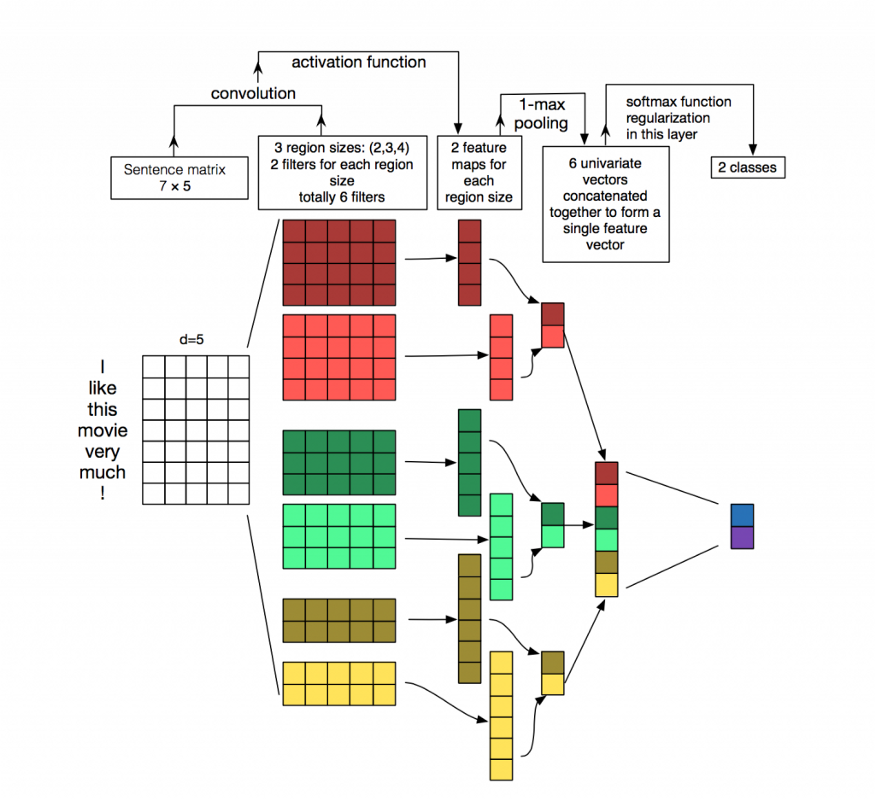

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embed_size, n_filters,  filter_sizes, pool_size, hidden_size, num_classes,
                 dropout):
        super().__init__()        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=1,
                                       out_channels=n_filters,
                                              kernel_size=(fs,embed_size))
                                    for fs in filter_sizes])
        self.max_pool1 = nn.MaxPool1d(pool_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(95*n_filters,hidden_size)
        #self.fc1 = nn.Linear(((embedded.shape[1]-filter_sizes[0]+1+embedded.shape[1]-filter_sizes[1]+1)//2)*n_filters, hidden_size, bias=True)  
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=True)  

    def forward(self, text, text_lengths):
        embedded = self.embedding(text) #
        #print(f'embedded.shape:{embedded.shape}') #64, 14, 300 = batch, 단어길이, embedding 길이
        embedded = embedded.unsqueeze(1)
        #print(f'embedded.shape : {embedded.shape}') #64, 1, 14, 300
        convolution = [conv(embedded) for conv in self.convs] #(64, 64, 12, 1) : embedded.shape[1]-filter_sizes[0]+1 / 64, 64, 7, 1 :embedded.shape[1]-filter_sizes[1]+1
        max1 = self.max_pool1(convolution[0].squeeze()) #64, 64, 6 = embedded.shape[1]-filter_sizes[0]+1 // pool_size

        max2 = self.max_pool1(convolution[1].squeeze()) #64, 64, 3 = embedded.shape[1]-filter_sizes[1]+1 // pool_size
        cat = torch.cat((max1, max2), dim=2) # 64, 64, 9 

        x = cat.view(cat.shape[0], -1)
        x = self.fc1(self.relu(x))
        x = self.dropout(x)
        x = self.fc2(x)  
        return x

In [ ]:
"""
Homer Simpson    27850
Marge Simpson    13172
Bart Simpson     12995
Lisa Simpson     10756

train : valid = 7:3

train label 비율 : tensor([0.4287, 0.2049, 0.2010, 0.1654], device='cuda:0')
valid label 비율 : tensor([0.4329, 0.1998, 0.1997, 0.1676], device='cuda:0')

"""

In [ ]:
model_ft=CNN(vocab_size,embedding_size,n_filters,filter_sizes,pool_size,hidden_size,num_classes,
             dropout_keep_prob).to(device)
#optimizer_ft=torch.optim.SGD(model_ft.parameters(), lr=0.001,momentum=0.9) #lr를 크게하면 발산해버린다
optimizer_ft=torch.optim.Adam(model_ft.parameters(), lr=0.001) #lr를 크게하면 발산해버린다
criterion = nn.CrossEntropyLoss().to(device)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min',factor=0.1,patience=2,
                                                  threshold=0.01,min_lr=1e-9,eps=1e-09)

In [ ]:
#SGD
model_ft,train_acc,valid_acc,train_loss,valid_loss = train_model(model_ft, criterion, optimizer_ft,scheduler=exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------
train Loss: 1.23729 Acc: 0.46167
valid Loss: 1.15364 Acc: 0.49929
last learning rate:[0.001]

Epoch 2/20
----------
train Loss: 1.09538 Acc: 0.52831
valid Loss: 1.14745 Acc: 0.50343
last learning rate:[0.001]

Epoch 3/20
----------
train Loss: 0.95728 Acc: 0.59617
valid Loss: 1.25147 Acc: 0.50157
last learning rate:[0.001]

Epoch 4/20
----------
train Loss: 0.79280 Acc: 0.67289
valid Loss: 1.41786 Acc: 0.48351
last learning rate:[0.0001]

Epoch 5/20
----------
train Loss: 0.57732 Acc: 0.77294
valid Loss: 1.63029 Acc: 0.48106
last learning rate:[0.0001]

Epoch 6/20
----------
train Loss: 0.50869 Acc: 0.79901
valid Loss: 1.81831 Acc: 0.47490
last learning rate:[0.0001]

Epoch 7/20
----------
train Loss: 0.46415 Acc: 0.81865
valid Loss: 2.00513 Acc: 0.47212
last learning rate:[1e-05]

Epoch 8/20
----------
train Loss: 0.42415 Acc: 0.83582
valid Loss: 2.02779 Acc: 0.46880
last learning rate:[1e-05]

Epoch 9/20
----------
train Loss: 0.42012 Acc: 0.83850
valid Loss: 2.

In [ ]:
#Adam
model_ft,train_acc,valid_acc,train_loss,valid_loss = train_model(model_ft, criterion, optimizer_ft,scheduler=exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------
train Loss: 1.24126 Acc: 0.45828
valid Loss: 1.16322 Acc: 0.48946
last learning rate:[0.001]

Epoch 2/20
----------
train Loss: 1.09396 Acc: 0.52690
valid Loss: 1.14935 Acc: 0.49889
last learning rate:[0.001]

Epoch 3/20
----------
train Loss: 0.95504 Acc: 0.59714
valid Loss: 1.22086 Acc: 0.49755
last learning rate:[0.001]

Epoch 4/20
----------
train Loss: 0.78809 Acc: 0.67410
valid Loss: 1.43363 Acc: 0.49034
last learning rate:[0.001]

Epoch 5/20
----------
train Loss: 0.64876 Acc: 0.73534
valid Loss: 1.63059 Acc: 0.46809
last learning rate:[0.001]

Epoch 6/20
----------
train Loss: 0.55318 Acc: 0.77681
valid Loss: 1.97394 Acc: 0.47738
last learning rate:[0.001]

Epoch 7/20
----------
train Loss: 0.48244 Acc: 0.80621
valid Loss: 2.23511 Acc: 0.45811
last learning rate:[0.001]

Epoch 8/20
----------
train Loss: 0.42307 Acc: 0.83114
valid Loss: 2.55022 Acc: 0.45659
last learning rate:[0.0001]

Epoch 9/20
----------
train Loss: 0.32853 Acc: 0.87418
valid Loss: 2.80

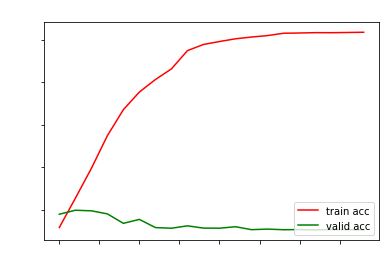

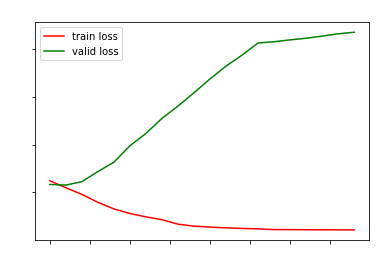

In [ ]:
plt.title('Accuracy',color='white')
plt.plot(train_acc, 'r', label='train acc')
plt.plot(valid_acc, 'g', label='valid acc')
plt.xlabel('Epochs',color='white')
plt.ylabel('Acc',color='white')
plt.legend(loc='lower right')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

plt.title('Loss',color='white')
plt.plot(train_loss,'r',label='train loss')
plt.plot(valid_loss,'g',label='valid loss')
plt.xlabel('Epochs',color='white')
plt.ylabel('Acc',color='white')
plt.legend()
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()


## 2) Linear model

In [ ]:
import torch.nn as nn 
class Linear(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Linear, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=True)
        
        #self.init_weights()

    def init_weights(self):
        initrange = 0.5
        
        nn.init.xavier_uniform_(self.fc1.weight.data)
        self.fc1.bias.data.zero_()
        nn.init.xavier_uniform_(self.fc2.weight.data)
        self.fc2.bias.data.zero_()
    
    def forward(self, text, text_lengths):
        text = text.float() # dense layer deals with float datatype
        x = self.fc1(text)
        x=self.relu(x)
        preds = self.fc2(x)
        return preds

In [ ]:
model_ft=Linear(max_document_length, hidden_size,num_classes).to(device)
#optimizer_ft=torch.optim.SGD(model_ft.parameters(), lr=1e-6,momentum=0.9) #lr를 크게하면 발산해버린다
optimizer_ft=torch.optim.Adam(model_ft.parameters(), lr=0.0001) #lr를 크게하면 발산해버린다
criterion = nn.CrossEntropyLoss().to(device)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min',factor=0.5,patience=2,
                                                  threshold=0.01,min_lr=1e-9,eps=1e-09)

In [ ]:
model_ft,train_acc,valid_acc,train_loss,valid_loss = train_model(model_ft, criterion, optimizer_ft,scheduler=exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 1.31389 Acc: 0.42741
valid Loss: 1.53935 Acc: 0.38222
last learning rate:[2.5e-05]

Epoch 2/100
----------
train Loss: 1.27594 Acc: 0.43676
valid Loss: 1.51137 Acc: 0.40931
last learning rate:[2.5e-05]

Epoch 3/100
----------
train Loss: 1.27450 Acc: 0.43959
valid Loss: 1.52446 Acc: 0.39229
last learning rate:[2.5e-05]

Epoch 4/100
----------
train Loss: 1.27346 Acc: 0.43854
valid Loss: 1.51644 Acc: 0.41352
last learning rate:[2.5e-05]

Epoch 5/100
----------
train Loss: 1.27226 Acc: 0.43859
valid Loss: 1.52910 Acc: 0.41151
last learning rate:[1.25e-05]

Epoch 6/100
----------
train Loss: 1.26047 Acc: 0.44605
valid Loss: 1.50178 Acc: 0.40735
last learning rate:[1.25e-05]

Epoch 7/100
----------
train Loss: 1.25882 Acc: 0.44499
valid Loss: 1.49941 Acc: 0.40661
last learning rate:[1.25e-05]

Epoch 8/100
----------
train Loss: 1.25943 Acc: 0.44545
valid Loss: 1.50187 Acc: 0.41408
last learning rate:[6.25e-06]

Epoch 9/100
----------
train Loss: 1.25185 A

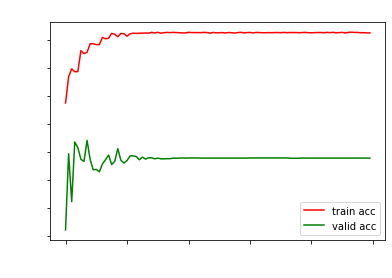

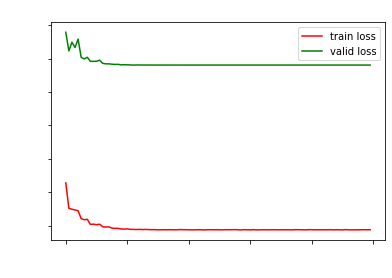

In [ ]:
plt.title('Accuracy',color='white')
plt.plot(train_acc, 'r', label='train acc')
plt.plot(valid_acc, 'g', label='valid acc')
plt.xlabel('Epochs',color='white')
plt.ylabel('Acc',color='white')
plt.legend(loc='lower right')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

plt.title('Loss',color='white')
plt.plot(train_loss,'r',label='train loss')
plt.plot(valid_loss,'g',label='valid loss')
plt.xlabel('Epochs',color='white')
plt.ylabel('Acc',color='white')
plt.legend()
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()
